In [8]:
import os

#import libraries
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
# Get the Data
import wget

if os.path.isfile('./AB_NYC_2019.csv'):
    print("AB_NYC_2019.csv data file: already exists, skip downloading")
else:
    target_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv"
    print("AB_NYC_2019.csv data file: downloading ....")
    wget.download(target_url, './AB_NYC_2019.csv')

AB_NYC_2019.csv data file: already exists, skip downloading


# 2.2 Data preparation

In [11]:
df = pd.read_csv('AB_NYC_2019.csv')
len(df)

48895

In [12]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [13]:
df['price']

0        149
1        225
2        150
3         89
4         80
        ... 
48890     70
48891     40
48892    115
48893     55
48894     90
Name: price, Length: 48895, dtype: int64

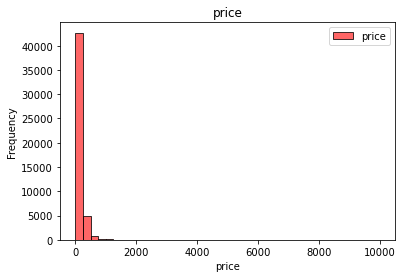

In [15]:
plt.figure(figsize=(6, 4))

sns.histplot(df['price'].values, label='price', color='red', alpha=0.6, bins=40)

plt.legend()
plt.ylabel('Frequency')
plt.xlabel('price')
plt.title('price')

plt.show()

Text(0.5, 1.0, 'price')

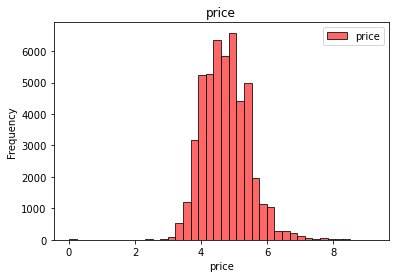

In [16]:

plt.figure(figsize=(6, 4))

sns.histplot(np.log1p(df['price'].values), label='price', color='red', alpha=0.6, bins=40)

plt.legend()
plt.ylabel('Frequency')
plt.xlabel('price')
plt.title('price')


# Filter only selective columns

In [18]:
df_house = df[['latitude',
                    'longitude',
                    'price',
                    'minimum_nights',
                    'number_of_reviews',
                    'reviews_per_month',
                    'calculated_host_listings_count',
                    'availability_365']]


df_house.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


# Question 1 - Find a feature with missing values. How many missing values does it have?

In [19]:
df_house.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Question 2 - What's the median (50% percentile) for variable 'minimum_nights'?

In [20]:
print("median (50% percentile) for variable 'minimum_nights':", df_house['minimum_nights'].median())

median (50% percentile) for variable 'minimum_nights': 3.0


# Split the data

In [21]:
np.random.seed(42)

n = len(df_house)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_house.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [22]:
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

# Question 3

In [23]:
df_train.isnull().sum()

latitude                             0
longitude                            0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 5998
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [24]:
df_val.isnull().sum()

latitude                             0
longitude                            0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 2051
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [25]:
df_test.isnull().sum()

latitude                             0
longitude                            0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 2003
calculated_host_listings_count       0
availability_365                     0
dtype: int64

### Linear Regression

In [26]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

### Baseline solution

In [29]:
base =['latitude',
        'longitude',
         'minimum_nights',
         'number_of_reviews',
         'reviews_per_month',
         'calculated_host_listings_count',
         'availability_365']

In [30]:
def prepare_X(df,filter,fillZero=True):
    df_num = df[filter]
    if fillZero == True:
        df_num = df_num.fillna(0)
    else:
        df_num = df_num.fillna(df_num.mean())
        
    #df_num.drop(df_num.columns[0], axis=1, inplace=True)
    X = df_num.values
    return X

In [31]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Fill missing values with zero

In [100]:
df_train.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
879,40.64354,-73.97777,3,62,0.71,1,189
44383,40.70666,-73.90779,21,0,NaN,1,73
15394,40.76116,-73.99016,2,17,0.43,1,0
43230,40.70763,-74.01050,2,5,1.88,327,272
16332,40.79658,-73.93287,2,30,0.80,1,30


In [33]:
#fill zeros
X_train = prepare_X(df_train,base,fillZero=True)
len(X_train)

29337

In [34]:
print(X_train.shape)

(29337, 7)


In [35]:
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

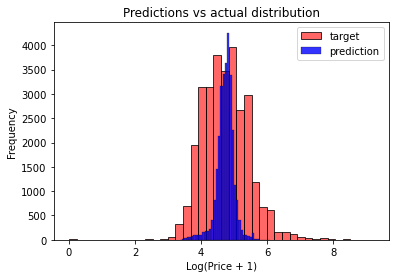

In [36]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [37]:
print('validation using traing set :', rmse(y_train, y_pred))

validation using traing set : 0.6428860484860424


In [38]:
X_val = prepare_X(df_val,base,fillZero=True)
y_pred = w_0 + X_val.dot(w)
rmse_val = rmse(y_val, y_pred)
rmse_val = round(rmse_val, 2)
print('validation using validation data set:', rmse_val)

validation using validation data set: 0.64


### Fill missing values with mean

In [39]:
#fill mean
X_train = prepare_X(df_train,base,fillZero=False)
len(X_train)

29337

In [40]:
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

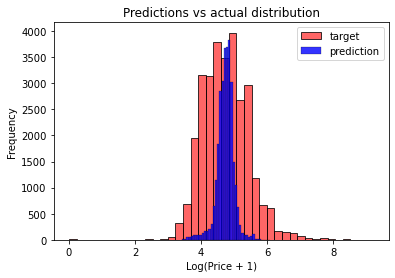

In [41]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [42]:
print('validation using training data set :', rmse(y_train, y_pred))

validation using training data set : 0.6429347474014244


In [43]:
X_val = prepare_X(df_val,base,fillZero=True)
y_pred = w_0 + X_val.dot(w)
rmse_val = rmse(y_val, y_pred)
rmse_val = round(rmse_val, 2)
print('validation using validation data set:', rmse_val)

validation using validation data set: 0.64


### plot for reviews_per_month

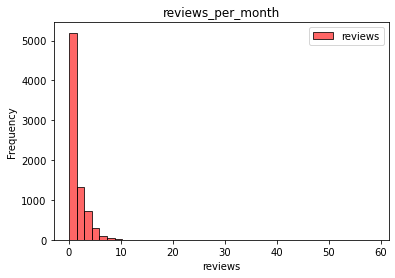

In [44]:
plt.figure(figsize=(6, 4))

sns.histplot(df_val['reviews_per_month'].values, label='reviews', color='red', alpha=0.6, bins=40)


plt.legend()

plt.ylabel('Frequency')
plt.xlabel('reviews')
plt.title('reviews_per_month')

plt.show()

# Regularization

In [45]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [46]:
X_train = prepare_X(df_train,base,fillZero=False)

In [47]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[1], w[4]))

    0, -423.54, -5.07, 0.01
0.001, -378.56, -4.58, 0.00
 0.01, -193.57, -2.57, -0.01
  0.1, -32.88, -0.82, -0.01
    1, -3.53, -0.49, -0.02
   10, -0.35, -0.42, -0.02


In [147]:
w

array([ 1.31148321e+00, -5.06799072e+00, -4.87741553e-04, -6.63849280e-04,
        5.34563277e-03,  1.32706019e-03,  6.38794182e-04])

In [57]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train,base,fillZero=True)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val,base,fillZero=True)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

0.0 -419.91265912865657 0.6430337788422453
1e-05 -419.4137642087844 0.6430371927907
0.0001 -414.9764930655632 0.6430723153539467
0.001 -375.27365313671316 0.6437669735169852
0.1 -32.5625605574363 0.6773299642434705
1 -3.49921683681115 0.6823116950148863
10 -0.35127676008960007 0.6828430212100617


In [58]:
r = 0.01
X_train = prepare_X(df_train,base,fillZero=True)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val,base,fillZero=True)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score

0.6557528427286351

In [59]:
r = 0.01
X_train = prepare_X(df_train,base,fillZero=True)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_test = prepare_X(df_test,base,fillZero=True)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

0.6656175809402669